## qflib Library Examples

In [1]:
import qflib as qf
import numpy as np
import os
import matplotlib.pyplot as plt
plt.style.use('ggplot')

print("qflib version: {0}".format(qf.version()))
print("pid: {0}".format(os.getpid()))

qflib version: 0.5.0-debug
pid: 10524


In [2]:
name = "World"
print(qf.sayHello(name))

Hello World!


In [3]:
x = [1, 2, 3]
y = [4, 5]
op = qf.outerProd(x, y)
print(f'x: {x}\ny: {y}')
print(f'outerProd:\n{op}')

x: [1, 2, 3]
y: [4, 5]
outerProd:
[[ 4.  5.]
 [ 8. 10.]
 [12. 15.]]


In [4]:
# Matrix Echo
m = np.array([[1, 2, 3], [4, 5, 6]])
em = qf.echoMatrix(m)
print(f'orig matrix:\n{m}')
print(f'echo matrix:\n{em}')

orig matrix:
[[1 2 3]
 [4 5 6]]
echo matrix:
[[1. 2. 3.]
 [4. 5. 6.]]


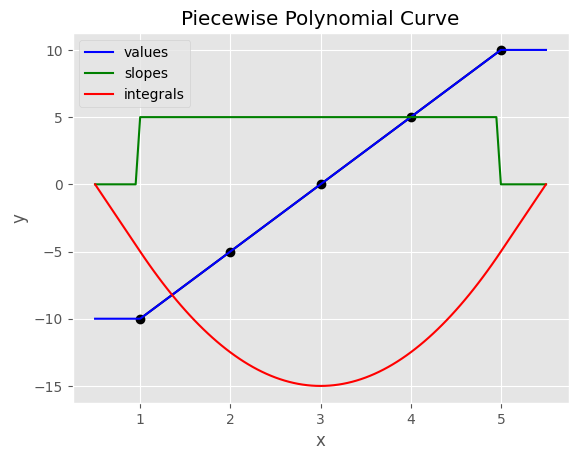

In [5]:
# Piecewise Polynomial Curves
xbpt = np.arange(1, 6)
yval =  np.arange(-10, 15, 5)
pord = 1
xval = np.arange(0.5, 5.55, 0.05)
pval = qf.ppolyEval(xbpt, yval, pord, xval, 0)
pder = qf.ppolyEval(xbpt, yval, pord, xval, 1)
pint = qf.ppolyIntegral(xbpt, yval, pord, xval[0], xval)

# plot
plt.plot(xbpt, yval, color='black', marker='o')
plt.plot(xval, pval, color='blue', label="values")
plt.plot(xval, pder, color='green', label="slopes")
plt.plot(xval, pint, color='red', label="integrals")
plt.title("Piecewise Polynomial Curve")
plt.legend(loc="upper left")
plt.xlabel('x')
plt.ylabel('y');

### Analytic Prices

In [6]:
#fwdprice
fwdpx = qf.fwdPrice(spot = 100, timetoexp = 1.0, intrate = 0.02, divyield = 0.04)
print('Forward price analytic solution')
print(f'Price={fwdpx:.4f}')

Forward price analytic solution
Price=98.0199


In [7]:
#digibs
digi = qf.digiBS(payofftype = 1, spot = 100, timetoexp = 1.0, strike = 100,
                  intrate = 0.02, divyield = 0.04, volatility = 0.2)
print('Digital option using Black-Scholes analytic solution')
print(f'Price={digi:.4f}')

Digital option using Black-Scholes analytic solution
Price=0.4124


In [8]:
#eurobs
euro = qf.euroBS(payofftype = 1, spot = 100, timetoexp = 1.0, strike = 100,
                  intrate = 0.02, divyield = 0.04, volatility = 0.4)
print('European option using Black-Scholes analytic solution')
print(f'Price={euro:.4f}')

European option using Black-Scholes analytic solution
Price=14.4327


In [9]:
import pandas as pd
# Given parameters
N = 10000  # Number of option units (short position)
K = 100    # Strike price
T = 2.0    # Time to expiration in years
r = 0.04   # Risk-free rate
q = 0.02   # Dividend yield
sigma = 0.30  # Volatility
payoff = 1  # 1 for call option

# Time points (quarterly)
times = np.array([0.00, 0.25, 0.50, 0.75, 1.00, 1.25, 1.50, 1.75, 2.00])

# Given spot prices
spot_prices = np.array([100.00, 105.00, 110.00, 92.00, 103.00, 90.00, 110.00, 95.00, 88.00])

# Initialize DataFrame with given values
df = pd.DataFrame({
    'Time': times,
    'Spot': spot_prices,
    'Option_Price': np.nan,  # To be calculated
    'Delta': np.nan,         # To be calculated
    'Growth': np.nan,        # To be calculated
    'Opt_Units': -N,         # We are short options
    'Stk_Units': np.nan,     # To be calculated
    'Opt_Val': np.nan,       # To be calculated
    'Stk_Val': np.nan,       # To be calculated
    'Cash_Acc': np.nan,      # To be calculated
    'Tot_Val': np.nan        # To be calculated
})

In [10]:
# Fill in the first row (t=0) with given values
df.loc[0, 'Option_Price'] = 17.78  # Given
df.loc[0, 'Delta'] = 0.60  # Given
df.loc[0, 'Growth'] = 1.0  # Initial value

# Calculate stock units for delta hedge (negative of option delta * option units)
df.loc[0, 'Stk_Units'] = -df.loc[0, 'Opt_Units'] * df.loc[0, 'Delta']

# Calculate position values
df.loc[0, 'Opt_Val'] = df.loc[0, 'Opt_Units'] * df.loc[0, 'Option_Price']
df.loc[0, 'Stk_Val'] = df.loc[0, 'Stk_Units'] * df.loc[0, 'Spot']

# Initial cash account: we deposit premium and withdraw money for stock purchase
df.loc[0, 'Cash_Acc'] = -df.loc[0, 'Opt_Val'] - df.loc[0, 'Stk_Val']

# Total value should be zero initially
df.loc[0, 'Tot_Val'] = df.loc[0, 'Opt_Val'] + df.loc[0, 'Stk_Val'] + df.loc[0, 'Cash_Acc']

# Now populate the rest of the DataFrame
for i in range(1, len(times)):
    # Time to expiration at this point
    tau = T - times[i]
    
    # Calculate option price and delta using qf.euroBS
    if tau > 0:
        # Call qf.euroBS which returns [Price, Delta, Gamma, Theta, Vega]
        greeks = qf.euroBS(payoff, spot_prices[i], K, tau, r, q, sigma)
        option_price = greeks[0]
        delta = greeks[1]
    else:
        # At expiration, option price is intrinsic value
        option_price = max(0, spot_prices[i] - K) if payoff == 1 else max(0, K - spot_prices[i])
        delta = 1.0 if spot_prices[i] > K else 0.0 if payoff == 1 else -1.0 if spot_prices[i] < K else 0.0
    
    # Growth factor for this period
    growth = np.exp(r * (times[i] - times[i-1]))
    
    # Record the values
    df.loc[i, 'Option_Price'] = option_price
    df.loc[i, 'Delta'] = delta
    df.loc[i, 'Growth'] = growth
    
    # Calculate stock units needed for new delta hedge
    df.loc[i, 'Stk_Units'] = -df.loc[i, 'Opt_Units'] * delta
    
    # Calculate values of positions
    df.loc[i, 'Opt_Val'] = df.loc[i, 'Opt_Units'] * option_price
    df.loc[i, 'Stk_Val'] = df.loc[i, 'Stk_Units'] * spot_prices[i]
    
    # Calculate cash account:
    # Previous cash grown at risk-free rate minus cost of adjusting stock position
    previous_cash = df.loc[i-1, 'Cash_Acc']
    cash_growth = previous_cash * growth
    stock_adjustment_cost = (df.loc[i, 'Stk_Units'] - df.loc[i-1, 'Stk_Units']) * spot_prices[i]
    df.loc[i, 'Cash_Acc'] = cash_growth - stock_adjustment_cost
    
    # Calculate total portfolio value
    df.loc[i, 'Tot_Val'] = df.loc[i, 'Opt_Val'] + df.loc[i, 'Stk_Val'] + df.loc[i, 'Cash_Acc']

# Format for display - set precision to match problem requirements
pd.options.display.float_format = '{:.2f}'.format

# Compute final P&L
final_pnl = df.loc[len(times)-1, 'Tot_Val']

TypeError: 'float' object is not subscriptable


Final P&L: $1085.73


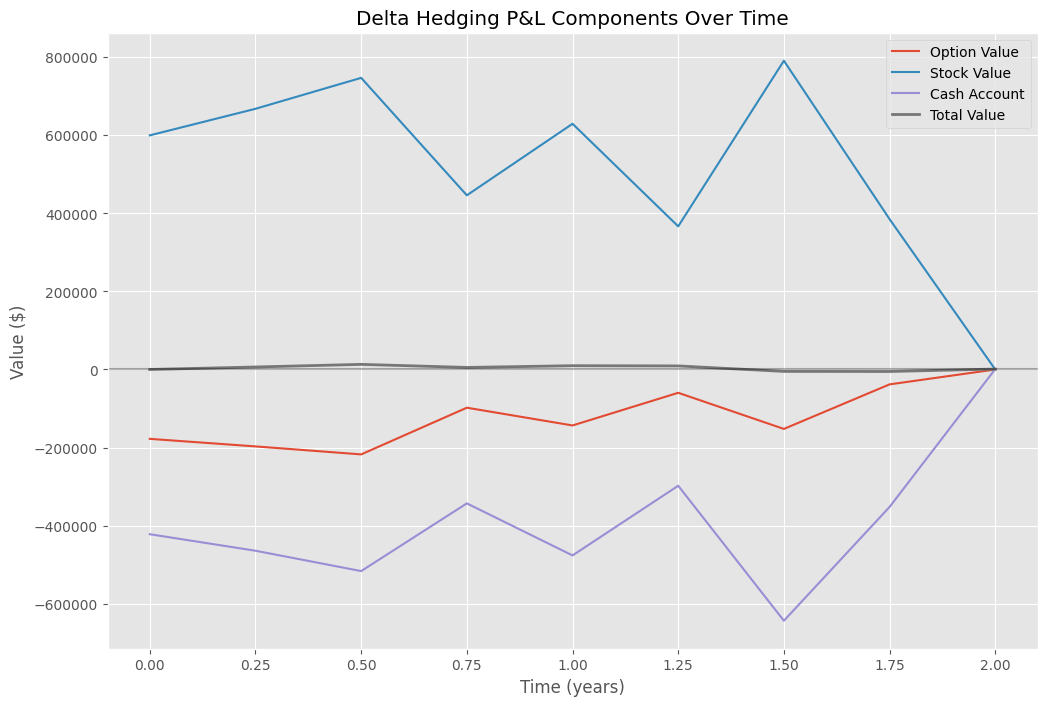

In [13]:
# Format the dataframe to match the required output
formatted_df = pd.DataFrame({
    'Time': df['Time'],
    'Spot Price': df['Spot'],
    'Delta': df['Delta'],
    'Growth': df['Growth'],
    'Opt_Units': df['Opt_Units'],
    'Stk_Units': df['Stk_Units'],
    'Opt_Val': df['Opt_Val'],
    'Stk_Val': df['Stk_Val'],
    'Cash_Acc': df['Cash_Acc'],
    'Tot_Val': df['Tot_Val']
})

# Display the DataFrame
print(formatted_df)
print(f"\nFinal P&L: ${final_pnl:.2f}")

# Optional: Plot the evolution of portfolio components and total value
plt.figure(figsize=(12, 8))
plt.plot(df['Time'], df['Opt_Val'], label='Option Value')
plt.plot(df['Time'], df['Stk_Val'], label='Stock Value')
plt.plot(df['Time'], df['Cash_Acc'], label='Cash Account')
plt.plot(df['Time'], df['Tot_Val'], label='Total Value', linewidth=2)
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.xlabel('Time (years)')
plt.ylabel('Value ($)')
plt.title('Delta Hedging P&L Components Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
df.head(10)

,Time,Spot,Option_Price,Delta,Growth,Opt_Units,Stk_Units,Opt_Val,Stk_Val,Cash_Acc,Tot_Val
0,0.00,100.00,17.78,0.60,1.00,-10000,6000.00,-177800.00,600000.00,-422200.00,0.00
1,0.25,105.00,19.72,0.64,1.01,-10000,6362.73,-197165.59,668086.41,-464529.59,6391.23
2,0.50,110.00,21.76,0.68,1.01,-10000,6794.34,-217624.33,747377.53,-516675.67,13077.53
3,0.75,92.00,9.80,0.49,1.01,-10000,4851.82,-97966.80,446367.63,-343156.59,5244.24
4,1.00,103.00,14.35,0.61,1.01,-10000,6113.44,-143464.81,629683.93,-476551.63,9667.49
5,1.25,90.00,5.98,0.41,1.01,-10000,4075.96,-59756.91,366836.25,-297968.05,9111.30
6,1.50,110.00,15.23,0.72,1.01,-10000,7193.51,-152324.79,791285.78,-643893.04,-4932.04
7,1.75,95.00,3.82,0.41,1.01,-10000,4056.06,-38185.31,385325.82,-352306.92,-5166.41
8,2.00,88.00,0.00,0.00,1.01,-10000,0.00,0.00,0.00,1085.73,1085.73
